En el ejemplo que voy a hacer ahora, los datos de entrada, van a ser exactos. En próximas investigaciones, voy a tener que meter ruido a esos datos para ver como influye en el ajuste del PINN.

Otro punto a tener en cuenta, es que se va a estudiar la solución para un estado sub-amortiguado. En el futuro también puede estudiarse diferentes modos de amortiguación.

**DEFINICIÓN DEL PROBLEMA**

In [1]:
'''
El planteamiento del problema está más detallado en el informe de esta misma
carpeta.

Para la resolución del problema hemos tenido que:
- Definir el fenómeno que quiere estudiarse: 1D harmónico oscilatorio amortiguado
- Definir las condiciones iniciales
- Definir cual de los 3 modos de amortiguamiento va a resolverse
- Definir la solución exacta para contrastarla con la obtenida por ANN & PINN

'''

'\nEl planteamiento del problema está más detallado en el informe de esta misma\ncarpeta.\n\nPara la resolución del problema hemos tenido que:\n- Definir el fenómeno que quiere estudiarse: 1D harmónico oscilatorio amortiguado\n- Definir las condiciones iniciales\n- Definir cual de los 3 modos de amortiguamiento va a resolverse\n- Definir la solución exacta para contrastarla con la obtenida por ANN & PINN\n\n'

**PLANTEAMIENTO DEL PROBLEMA**

In [2]:
'''
1) Definir la solución exacta
2) Extraer 10 puntos de dicha solución
3) Esos 10 puntos, van a ser utilizados para:
  3.1) Entrenar un RNA
  3.2) Entrenar un PINN

El objetivo va a ser resaltar la diferencia entre ambas redes y llegar a la
conclusión de que con muchos menos puntos, una PINN puede ajustarse
correctamente a una solución exacta.

'''

'\n1) Definir la solución exacta\n2) Extraer 10 puntos de dicha solución\n3) Esos 10 puntos, van a ser utilizados para:\n  3.1) Entrenar un RNA\n  3.2) Entrenar un PINN\n\nEl objetivo va a ser resaltar la diferencia entre ambas redes y llegar a la\nconclusión de que con muchos menos puntos, una PINN puede ajustarse\ncorrectamente a una solución exacta.\n\n'

**DEFINIR EL PROBLEMA**

In [3]:
# Lo primero es importar las librerias que van a hacer falta
# las redes se van a construir con pytorch

from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Se define una funcion para guardar el GIF
'''
Parámetros de la función:
- outfile: Es la ruta y el nombre del archivo GIF de salida.
- files: Es una lista de rutas a los archivos de imagen que se utilizarán para crear el GIF.
- fps: Es el número de cuadros por segundo (frames per second) que se desea para el GIF. Por defecto, se establece en 5.
- loop: Especifica el número de veces que el GIF debe repetirse. Un valor de 0 indica que se debe repetir infinitamente
'''

'''
Parámetros .save()
- fp=outfile: La ruta y el nombre del archivo de salida.
- format='GIF': Indica que el formato del archivo de salida es GIF.
- append_images=imgs[1:]: Una lista de imágenes que se agregarán al archivo GIF después de la primera imagen.
- save_all=True: Indica que se deben guardar todas las imágenes en la lista proporcionada.
- duration=int(1000/fps): La duración de cada cuadro en milisegundos, calculada como el inverso del número de cuadros por segundo.
- loop=loop: El número de veces que el GIF debe repetirse.
'''

def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [5]:
# CALCULAR LA SOLUCIÓN ANALÍTICA PARA EL PROBEMA DEL OSCILADOR ARMÓNICO SUBAMORTIGUADO 1D

'''
Parámetros de la función:
- d: Es el coeficiente de amortiguamiento.
- w0: Es la frecuencia angular natural del oscilador.
- x: Es la variable independiente, generalmente el tiempo.
'''

'''
d tiene que ser menor que w0 --> condición para oscilador armónico subamortiguado
si d fuera mayor o igual a w0, tendriamos un sistema diferente, por lo que, el problema tendría un enfoque diferente
para asegurarno de que se cumple la condición utilizo:  assert d < w0
en caso de que no se cumpla la condición, assert hace que se detenga el programa
'''

'''
Hay que hacer unos cálculos intermedios para que la función final sea lo más breve posible
- w: frecuencia angular efectiva
- phi: ángulo de fase
- A: amplitud
'''
def oscillator(d, w0, x):

  assert d < w0

  w = np.sqrt(w0**2-d**2)
  phi = np.arctan(-d/w)
  A = 1/(2*np.cos(phi))

  cos = torch.cos(phi+w*x)
  sin = torch.sin(phi+w*x)

  exp = torch.exp(-d*x)

  y  = exp*2*A*cos

  return y

In [6]:
class RNA(nn.Module):
  def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
    super().__init__()
    activation = nn.Tanh
    self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
    self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)])
    self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
  def forward(self, x):
      x = self.fcs(x)
      x = self.fch(x)
      x = self.fce(x)

      return x

In [7]:
# REPRESENTAR LA RNA para contrastar con la solución analítica

'''
  Dentro del método __init__ se definen 4 parámetros
  Más adelante ene el programa, se llamará al modelo de la siguiente forma: model = RNA(1,1,32,3)
  Definiendo de esta forma una RNA con 1 input, 1 output, 32 neuronas por capa, 3 capas ocultas
  Por lo que los parámetros de la RNA no quedán fijados desde un primer instante
  - N_INPUT: Número de neuronas en la capa de entrada.
  - N_OUTPUT: Número de neuronas en la capa de salida.
  - N_HIDDEN: Número de neuronas en cada capa oculta.
  - N_LAYERS: Número de capas ocultas en la red.
  '''

'''
  self.fcs es la capa de entrada de la RNA
  self.fch son las capas ocultas de la RNA
  self.fce es la capa de salida de la RNA
  '''
'''
  - .fcs: fully connected
  - nn.Sequential: clase de pytorch para apilar capas y funciones de activación
  - *: los elementos de las listas se pasarán como argumentos individuales
  - Esta capa tiene a N_INPUT como input y N_HIDDEN como output
  - activation(): función de activación entre ambas capas, definida previamente
  '''


'''
  El método forward especifica como los datos se propagan a través de las capas de la RNA
  En este caso, va a tomar el tensor x de entrada
  '''


'\n  El método forward especifica como los datos se propagan a través de las capas de la RNA\n  En este caso, va a tomar el tensor x de entrada\n  '

**GENERAR EL "TRAINING DATA"**

In [8]:
'''
Para generar esta data, en un primer instante, va a generarse a partir de la solución analítica
En un futuro, puede introducirse ruido a esta data y ver como influye en los ajustes de las redes
Tambien puede estudiarse para un dominio mayor, diferentes coeficientes, cantidad de puntos...

Para este problema, va a utilizarse un coeficiente de amortiguación (d = 2)
Para este problema, va a utilizarse una frecuencia angular natural (w0 = 20)
'''

'\nPara generar esta data, en un primer instante, va a generarse a partir de la solución analítica\nEn un futuro, puede introducirse ruido a esta data y ver como influye en los ajustes de las redes\nTambien puede estudiarse para un dominio mayor, diferentes coeficientes, cantidad de puntos...\n\nPara este problema, va a utilizarse un coeficiente de amortiguación (d = 2)\nPara este problema, va a utilizarse una frecuencia angular natural (w0 = 20)\n'

Tamaño original de los tensores x: torch.Size([500, 1]) y y: torch.Size([500, 1])
Tamaño reducido de los tensores x: torch.Size([10, 1]) y y: torch.Size([10, 1])


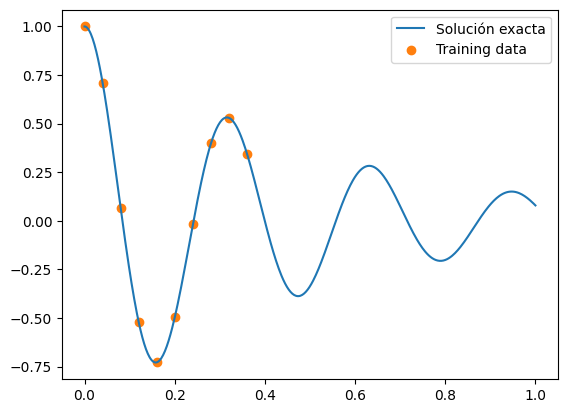

In [9]:
# Obtener y dibujar la solución analítica para el dominio x(0,1)
d, w0 = 2, 20

'''
x --> tensor de 500 puntos equiespaciados en el dominio de 0 a 1
y --> La función oscilator le pide 3 parámetros de entrada d, w0 y cantidad de puntos los que aplicar la ecuacion
      habiendo definido el tensor x le pasamos cada punto del tensor a la función oscillator y calcula la ecuación
      para cada uno de ellos
.view(-1,1) --> organiza los puntos en una matriz columna
'''
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(f'Tamaño original de los tensores x: {x.shape} y y: {y.shape}')

'''
Ahora vamos a seleccionar los puntos que vamos a utilizar para el entrenamiento de las redes
Para ello vamos a recurrir a la técnica LHS (left hand side)
x_data = x[0:200:20]
  - Selecciona los primeros 200 puntos de x
  - Cada 20 puntos se guarda 1
  - Es decir, tendremos un total de 10 puntos
Del tensor x obtendremos la posición del punto en el que está siendo evaluada la ecuación
Del tensor y obtendremos el valor de la ecuación en ese punto
'''
x_data = x[0:200:20]
y_data = y[0:200:20]
print(f'Tamaño reducido de los tensores x: {x_data.shape} y y: {y_data.shape}')

# Graficar la solución exacta y los 10 puntos seleccionados
plt.figure()
plt.plot(x, y, label="Solución exacta")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

**RNA**

In [10]:
'''
Una vez seleccionada la data es hora de entrenar la primera red neuronal
En este primer instante se va a entrenar la RNA de toda la vida
No se va a tener en cuenta la física que rodea al problema
'''

'''
A continuación, va a imprimirse la grafica, con la solución analítica, los puntos de entrenamiento y la prediccion de la RNA
'''

'\nA continuación, va a imprimirse la grafica, con la solución analítica, los puntos de entrenamiento y la prediccion de la RNA\n'

In [11]:
import os
# Definir la función que va a crear las gráficas
# Establecer que parámetros hay que pasarle y que caracteristicas tendrán dentro de la gráfica
def plot_result(x,y,x_data,y_data,yh,xp=None):
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')

# xp es para el PINN, se explica más adelante
# Si xp es algo, significa que estamos optimizando con PINN, entonces que se grafiquen los puntos en los cuales se evaluan las derivadas
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axhline(y=0, color='black', linestyle='-')
    plt.axis("on")


# Entrenamiento de la RNA

# Con esto establecemos la semilla aleatoria para asegurar que los resultados sean reproducibles
torch.manual_seed(123)

# En este caso, el model es la class definida como RNA, en la que le pasamos los parámetros 1,1,32,3
model = RNA(1,1,32,3)

# El siguiente paso es definir el optimizador y el learning rate de la RNA
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

# Inicializamos una lista para almacenar los nombres de los archivos que quieren guardarse
files = []
losses =[]

main_output_dir = "/content/drive/MyDrive/GITHUB/3_PINNS/Harmonic_oscillator_PINN/Graficas"
os.makedirs(main_output_dir, exist_ok=True)

# Crear carpeta de salida
output_dir = "/content/drive/MyDrive/GITHUB/3_PINNS/Harmonic_oscillator_PINN/Graficas/ANN"
output_gif_path = "/content/drive/MyDrive/GITHUB/3_PINNS/Harmonic_oscillator_PINN/Graficas/ANN/nn.gif"
os.makedirs(output_dir, exist_ok=True)

# Inicializamos el bucle de entrenamiento
for i in range(10000):

    # Necesario poner a cero los gradientes para la optimizacion, ya que si no se acumula su valor
    optimizer.zero_grad()

    # Realizar una propagación hacia adelante a través de la red, generando las predicciones del modelo
    # No es necesario poner model.forward, ya que ya está definido en el class RNA
    yh = model(x_data)

    # Calcular las pérdidas del entrenamiento
    loss_function = nn.MSELoss()
    loss = loss_function(yh, y_data)

    # Guardar las pérdidas en una lista. .item() para guardar el valor del tensor
    losses.append(loss.item())

    # Retropropagación del error en la pérdida. Esto calcula los gradientes de la pérdida con respecto a los parámetros del modelo
    loss.backward()
    #.step() -->  Actualiza los parámetros del modelo utilizando el optimizador
    optimizer.step()


    # Graficar y guardar los resultados
    if (i+1) % 500 == 0:

        # Predice los valores de y para los valores de x que le van a pasando por model()
        # model = RNA
        # .detach --> evita la propagacion de gradientes
        yh = model(x).detach()

        # Grafica la solución exacta, los puntos de entrenamiento y el resultado de la RNA
        # Para graficar hace el uso de la función definida al principio de esta celda, en la que pone que parámetros hay que pasarle
        # Todo esto en el rango de x e y
        plot_result(x,y,x_data,y_data,yh)

        # Guarda la imagen en la carpeta definida %.5i asegura que el nombre tenga 5 digitios, rellenando con 0 si hace falta
        # Definir los parametros para guardar la imagen
        # Guardar los nombres en una lista por si luego se quiere hacer algún gif
        file = os.path.join(output_dir, "ANN_%.5i.png" % (i+1))
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        # Imprimir en pantalla la gráfica cada 500 iteraciones, para ver la evolución
        if (i+1) % 500 == 0:
          plt.show()
        else: plt.close("all")

save_gif_PIL(output_gif_path, files, fps=20, loop=0)

Output hidden; open in https://colab.research.google.com to view.

**PÉRDIDAS**

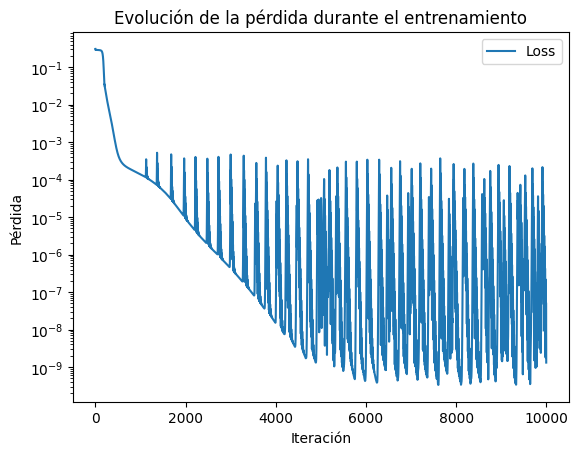

In [12]:
# Gráfica de las pérdidas durante el entrenamiento
plt.plot(losses, label='Loss')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.yscale('log')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.legend()
plt.show()

**PINN**

In [13]:
'''
- A continuación, se va a crear el PINN
- A diferencia de la RNA, PINN lleva incorporada la ecuación diferencial en la función de pérdida
- De esta forma nos aseguramos que la solución aprendida es consistente con la ecuacion diferencial
- Esto se hace penalizando el residuo de la ecuación diferencial sobre un conjunto de ubicaciones muestreadas del dominio

- En un primer caso, se va a evaluar la pérdida física en 30 puntos uniformemente distribuidos en el dominio [0, 1]
- Gracias a las características de autodiferenciacion de pytorch, se pueden calcular las derivadas de la solucion de
  la red respecto a la variable de entrada en estos puntos
'''

'\n- A continuación, se va a crear el PINN\n- A diferencia de la RNA, PINN lleva incorporada la ecuación diferencial en la función de pérdida\n- De esta forma nos aseguramos que la solución aprendida es consistente con la ecuacion diferencial\n- Esto se hace penalizando el residuo de la ecuación diferencial sobre un conjunto de ubicaciones muestreadas del dominio\n\n- En un primer caso, se va a evaluar la pérdida física en 30 puntos uniformemente distribuidos en el dominio [0, 1]\n- Gracias a las características de autodiferenciacion de pytorch, se pueden calcular las derivadas de la solucion de\n  la red respecto a la variable de entrada en estos puntos\n'

In [14]:
# Se define el tensor de 30 puntos en el dominio [0,1] que contiene ubicaciones de muestra sibre el dominio del problema
# con requires_grad_(True), declaramos que las operaciones posteriores puedas ser diferenciables
# Hay que definir el punto en el que se va a evaluar la pérdida por la condición de contorno
x_boundary = torch.tensor(0., requires_grad=(True)).view(-1,1)
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# Condiciones del sistema subamortiguado
mu, k = 2*d, w0**2

# Definir la RNA, que va a ser optimizado según la función de pérdida que contenga la información de las ecuaciones diferenciales parciales
torch.manual_seed(123)
model = RNA(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

files = []
losses_1 = []
losses_2 = []
losses_3 = []
losses_PINN = []

# Definir como se van a calcular las pérdidas
loss_function = nn.MSELoss()

# Crear carpeta de salida
pinn_output_dir = "/content/drive/MyDrive/GITHUB/3_PINNS/Harmonic_oscillator_PINN/Graficas/PINN"
output_pinn_gif_path = "/content/drive/MyDrive/GITHUB/3_PINNS/Harmonic_oscillator_PINN/Graficas/PINN/pinn.gif"
os.makedirs(pinn_output_dir, exist_ok=True)

# Inicio del bucle de optimización
for i in range(20000):

# Reinicio de los gradientes, para que no se acumulen
    optimizer.zero_grad()

    # Pérdidas 1: rendimiento del modelo en los datos de entrenamiento
    # Utilizando el modelo de red neuronal (model), se hace una predicción (yh) para los datos de entrada de entrenamiento (x_data)
    # x_data son los puntos naranjas definidos previamente
    yh = model(x_data)
    # Después de obtener las predicciones del modelo, se calcula el error entre las predicciones y los datos de entrenamientos reales
    loss_1 = loss_function(yh, y_data)
    # Guardar las pérdidas en una lista. .item() para guardar el valor del tensor
    losses_1.append(loss_1.item())

    # Pérdidas 2: Pérdidas por las condiciones de contorno
    yhbc = model(x_boundary)
    dx = torch.autograd.grad(yhbc, x_boundary, torch.ones_like(yhbc), create_graph=True)[0]
    loss_2 = (1e-4)*torch.squeeze((dx)**2)
    losses_2.append(loss_2.item())

    # Pérdidas 3: Pérdidas físicas
    # Definido al principio de la celda: se van a predecir los resultados en 30 puntos
    # Con esto se quiere destacar que la cantidad de puntos a evaluar para una pérdida y otra, no tienen porqué ser iguales
    yhp = model(x_physics)

    # Ahora se procede a calcular las derivadas de segundo orden
    # La función torch.autograd.grad, calcula automáticamente gradientes de tensores

    # Primero hay que calcular la primera derivada de las predicciones del modelo en las ubicaciones de muestra de física yhp
    # yhp --> función respecto a la cual estamos calculando el gradiente
    # yhp son las predicciones del modelo en las ubicaciones de muestra de física
    # x_physics --> Argumento respecto al que estamos calculando el gradiente
    # x_physics representa las ubicaciones de muestra física donde queremos calcular las derivadas
    # torch.ones_like(yhp) --> Este tensor se utiliza como el gradiente inicial para calcular la derivada
    # Consideramos que el gradiente inicial es 1 para cada elemento
    # Esto se hace debido a que en pytorch es necesario especificar el gradiente inicial para la primera derivada cuando se calculan derivadas de segundo orden
    # create_graph=True --> necesario para rastrear las operaciones realizadas para calcular las derivadas
    # [0] --> la función .grad, devuelve una lista con los gradientes en todos los puntos de x_physics,
    # pero poniendo .[0], solo accede al valor de la primera fila
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0] #dy/dx
    # Después hay que calcular la segunda derivada de las predicciones del modelo en las ubicaciones de muestra de física yhp
    # Misma explicación que la anterior
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0] #d^2y/dx^2

    # Después de haber calculado las derivadas es momento de definir la física del problema
    # En este caso estamos definiendo la ecuación diferencial "1D damped harmonic oscillator"
    physics = dx2 + mu*dx + k*yhp

    # Ahora toca calcular y guardar el valor de los residuos debidos a la ecuación diferencial
    # torch.mean --> calcula la media del tensor physics
    # physics está elevado al cuadrado para eliminar valores negativos
    #  (1e-4) --> el valor promedio es multiplicado por este pequeño valor para escalar la pérdida asociada a la ecuación diferencial
    # Reduce la magnitud de la pérdida, lo que puede ayudar a controlar su influencia en el proceso de optimización
    loss_3 = (1e-4)*torch.mean(physics**2)
    # Guardar las pérdidas en una lista. .item() para guardar el valor del tensor
    losses_3.append(loss_3.item())

    # Calcular la pérdida total: suma de la pérdida del modelo y la pérdida de la ED
    loss_PINN = loss_1 + loss_2 + loss_3
    losses_PINN.append(loss_PINN.item())

    # Retropropagación de la pérdida: retropropagación del gradiente a través de la red neuronal.
    # Durante la retropropagación, se calculan los gradientes de la pérdida con respecto a todos los parámetros del modelo.
    # Estos gradientes se utilizan luego para ajustar los parámetros durante la etapa de optimización.
    loss_PINN.backward()
    # Actualización de los parámetros del modelo: Después de retropropagar el gradiente este método actualiza los parámetros del modelo utilizando el algoritmo de optimización especificado (en este caso, el algoritmo Adam)
    # Durante esta etapa, los parámetros del modelo se ajustan en la dirección que reduce la pérdida total, lo que ayuda al modelo a mejorar su capacidad para hacer predicciones precisas.
    # En este caso (PINN), la pérdida total es la suma
    optimizer.step()


    # plot the result as training progresses
    if (i+1) % 500 == 0:

        yh = model(x).detach()
        xp = x_physics.detach()

        plot_result(x,y,x_data,y_data,yh,xp)

        file = os.path.join(pinn_output_dir, "PINN_%.5i.png" % (i+1))
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")

save_gif_PIL(output_pinn_gif_path, files, fps=20, loop=0)

Output hidden; open in https://colab.research.google.com to view.

**PÉRDIDAS**

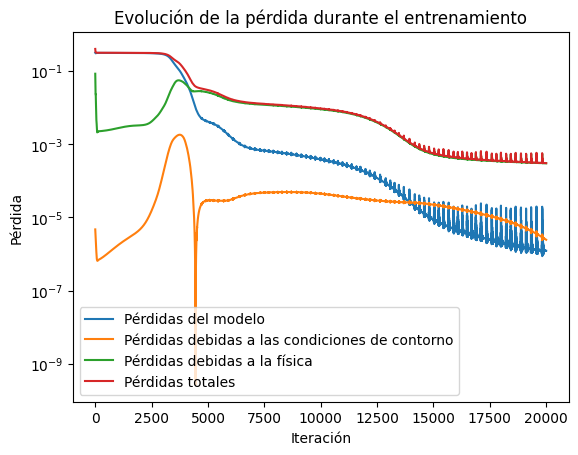

In [15]:
# Gráfica de las pérdidas durante el entrenamiento
plt.plot(losses_1, label='Pérdidas del modelo')
plt.plot(losses_2, label='Pérdidas debidas a las condiciones de contorno')
plt.plot(losses_3, label='Pérdidas debidas a la física')
plt.plot(losses_PINN, label='Pérdidas totales')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.yscale('log')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.legend()
plt.show()